***Disclaimer:** This code was written for the sole educational purpose of
helping practitioners understand differential privacy concepts.*

***This code is not suitable for use in production environments that process
sensitive data.***

*One security issues with running this code in a production setting is that it
is susceptible to side-channel attacks related to the use of floating point
values. Other security issues surely exist, and we make no effort to enumerate
all of them.*

---------------------------------------------------------------------------------

# Counting Queries

This Python notebook shows how to perform basic counting queries using the
differential privacy Laplace mechanism. The notebook covers reading in data from
a file, preprocessing it, running the query, and invoking the mechanism to
satisfy differential privacy. In addition to implementing the query, we also
demonstrate how to quantify and visualize query accuracy.

As a running example, let's answer the following question using a simple dataset
containing transaction data from a coffee shop:

**How many pumpkin spice lattes have been sold?**

To achieve this using differential privacy, we will complete the following
steps:

1. Read in the transaction data from the coffee shop
2. Select the `product` column from the data; this column indicates which
   product was sold in the transaction
3. Filter the results to include just pumpkin spice lattes
4. Count the number of rows
5. Add noise with the Laplace mechanism to achieve differential privacy

Before we start writing code, let's import a few third-party Python packages. We
will use `csv` for importing datasets encoded in CSV format into Python data
objects, `numpy` for the ability to sample numbers from the Laplace
distribution, and `random` for sampling subsets of the data chosen at random.

In [1]:
import csv
import numpy
import random
import matplotlib.pyplot as plt
import ipywidgets

## Step 1: Reading in the Data

Our first step is to load the data. We read the CSV file into variable
`input_data` using regular Python functions, and we also define `col_names` to
contain the column names for the dataset.

In [2]:
filename = "lattes.csv"
with open(filename) as input_file:
    input_data = list(csv.reader(input_file))
    
col_names = ["id", "product", "price"]

Let's print out the dataset and take a look at what is inside.

In [3]:
print(f"The data has {len(col_names)} columns::")
print(col_names)
print(f"The data has {len(input_data)} rows:")
for row in input_data:
    print(row)

The data has 3 columns::
['id', 'product', 'price']
The data has 1000 rows:
['1', 'Coffee', '$2.04']
['2', 'Coffee', '$1.55']
['3', 'Pumpkin Spice Latte', '$5.94']
['4', 'Pumpkin Spice Latte', '$3.67']
['5', 'Latte', '$4.15']
['6', 'Latte', '$3.47']
['7', 'Latte', '$1.37']
['8', 'Coffee', '$5.50']
['9', 'Latte', '$4.54']
['10', 'Latte', '$1.32']
['11', 'Pumpkin Spice Latte', '$5.89']
['12', 'Latte', '$4.42']
['13', 'Latte', '$1.08']
['14', 'Latte', '$2.74']
['15', 'Latte', '$1.53']
['16', 'Coffee', '$3.07']
['17', 'Latte', '$2.31']
['18', 'Pumpkin Spice Latte', '$1.24']
['19', 'Pumpkin Spice Latte', '$2.33']
['20', 'Coffee', '$5.24']
['21', 'Latte', '$3.08']
['22', 'Latte', '$4.73']
['23', 'Pumpkin Spice Latte', '$3.53']
['24', 'Pumpkin Spice Latte', '$4.46']
['25', 'Coffee', '$4.86']
['26', 'Coffee', '$1.72']
['27', 'Latte', '$2.68']
['28', 'Coffee', '$2.02']
['29', 'Pumpkin Spice Latte', '$5.85']
['30', 'Latte', '$3.72']
['31', 'Coffee', '$4.63']
['32', 'Latte', '$2.56']
['33', 'Latt

## Step 2: Selecting the Product Column

Our second step is to select the `product` column of the data. We do this using
standard python functions and a list comprehension expression, and call this
operation `query1`. After defining the function we print out the first five
results.

In [4]:
def query1(data):
    return [ row[col_names.index("product")]  
             for row
             in data 
           ]

print("The product type for transactions 1–5:")
for x in query1(input_data)[:5]:
    print(x)

The product type for transactions 1–5:
Coffee
Coffee
Pumpkin Spice Latte
Pumpkin Spice Latte
Latte


## Step 3: Filter and Count

Now we're ready to count the number of pumpkin spice lattes. The results tell us
(without differential privacy) how many pumpkin spice lattes were sold. To
create this query, we reuse `query1` from before that selects the `"product"`
column, and count up the elements that are pumpkin spice lattes. We call this
operation `query2`, and after defining the function we print out the results.

In [5]:
def query2(data): 
    return sum([ 1 if product == "Pumpkin Spice Latte" else 0 
                 for product 
                 in query1(data) ])
  
print("The number of 'Pumpkin Spice Latte' product types:")
print(query2(input_data))

The number of 'Pumpkin Spice Latte' product types:
331


## Step 4: Laplace Mechanism

The last step is to apply the Laplace mechanism in order to achieve differential
privacy. To apply the Laplace mechanism we sample noise from the Laplace
distribution and add it to the query count (the
output of `query2`).

In order to achieve the correct quantity of privacy we need to use the correct
scale parameter when sampling from the Laplace distribution. This correct scale
parameter depends on the *sensitivity* of the query whose result we are adding
noise to (`query2` in this case), as well as the desired *privacy budget*
$\epsilon$ we would like to obtain. The formula for the Laplace scale parameter
is $sensitivity / \epsilon$. In our case the query has $sensitivity = 1$, and we
have decided to pick $\epsilon = 0.1$ for the privacy budget, so we use a scale
of $1/0.1 = 10$ for the noise parameter.

We call this operation `query3`, and after defining the function we print out
the results. Note that the result is based on sampling random noise, so the
output will be different every time the function is called.

In [6]:
sensitivity = 1
epsilon = 0.1
noise_scale = sensitivity / epsilon

def query3(data):
    return query2(data) + numpy.random.laplace(0, noise_scale)

print("(Running multiple times will give different results each time.)")
print("A differentially private count of Pumpkin Spice Lattes in the dataset:")
print(query3(input_data))

(Running multiple times will give different results each time.)
A differentially private count of Pumpkin Spice Lattes in the dataset:
323.57855412344014


## Accuracy

Let's try to get a sense of how *accurate* the differentially private results
are. We expect that when called multiple times, the average of all results
(i.e., the mean) will be equal to the true count. And we are interested on how
spread out the results are in general (i.e., the variance). Let's test this
empirically by performing one-thousand trials and computing the mean and
variance.

In [7]:
trials = [ query3(input_data) 
           for _ 
           in range(0, 1000) 
         ]

print("(Running multiple times will give different results.)")
print("Empirical mean and variance for 1000 samples:")
print(f"mean: {numpy.mean(trials)}")
print(f" var: {numpy.var(trials)}")

(Running multiple times will give different results.)
Empirical mean and variance for 1000 samples:
mean: 330.4299119957137
 var: 179.0723055181324


In fact, because we can characterize the exact distribution of values the
results are drawn from—the Laplace distribution—we can also just calculate the
mean and variance without doing any trials. The formula for variance is
$variance = 2 * scale^2$. We call these the *analytic* mean and variance because
they are calculated directly, as opposed to the *empirical* mean and variance,
which are estimated based on random trials. Notice that the analytic mean and
variance are very likely to be slightly different than the empirical ones. As we
perform more and more random trials to compute the empirical mean, we expect
them to come closer and closer together.

In [8]:
analytic_mean = query2(input_data)
analytic_variance = 2 * noise_scale ** 2

print("Analytic mean and variance:")
print(f"mean: {analytic_mean}")
print(f"var: {analytic_variance}")

Analytic mean and variance:
mean: 331
var: 200.0


Now we know the variance of the result is 200. However, interpreting this number
(the distribution variance) isn't very intuitive. A common method for making
distribution variance more interpretable is to convert the quantity to a *95%
confidence interval* (95% CI) represented as a numeric range (lower bound and
upper bound). 95% of the time, samples from the distribution will fall within
the 95% CI range, and the 95% CI for a dataset with $N$ elements is computed
using the formula $CI = 1.96 * \frac{\sqrt{variance}}{\sqrt{N}}$.

We would like to visualize the 95% CI range for a number of different choices
for $\epsilon$. To do this we will create a line and error bar plot with choices
for $\epsilon$ on the $x$ axis, the mean of `query3` (for that choice of
$\epsilon$) on the $y$ axis, and the 95% CI as error bars. The mean of `query3`
is independent from the choice of $\epsilon$, so the line will be a straight
horizontal line, but the 95% CI (calculated from the variance) will change for
different choices of $\epsilon$.

(330.0, 332.0)

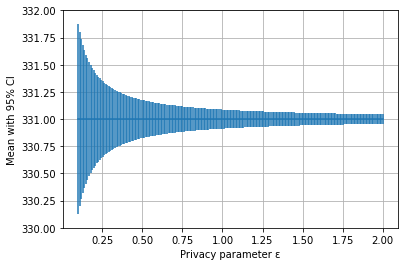

In [9]:
def analytic_variance_from_epsilon(epsilon):
    sensitivity = 1
    noise_scale = sensitivity / epsilon
    return 2 * noise_scale ** 2

def ci_from_variance(variance, samples):
    return 1.96 * numpy.sqrt(variance) / numpy.sqrt(samples)

# plot 200 epsilon values from 0.1 to 2.0 on x-axis
epsilons = numpy.linspace(0.1, 2.0, 200)

# for each epsilon (x-axis), plot the analytic mean and associated 95% CI
plt.errorbar(epsilons,
             [analytic_mean for epsilon in epsilons],
             [ci_from_variance(analytic_variance_from_epsilon(epsilon), 
                               len(input_data)) \
              for epsilon in epsilons])
plt.grid()
plt.xlabel("Privacy parameter ε")
plt.ylabel("Mean with 95% CI")
plt.ylim((330,332))

Another nice way to interpret the variance of a distribution is to just
visualize the distribution itself in a histogram plot. Let's create a histogram
of `query3` output for 20 different choices of $\epsilon$. This will create an
interactive histogram plot where changing the slider will recreate the histogram
for each value of $\epsilon$.

In [10]:
def many_query3_from_epsilon(epsilon):
    sensitivity = 1
    noise_scale = sensitivity / epsilon
    return numpy.random.laplace(0, noise_scale, size=1000) + query2(input_data)

# run query 3 for epsilon values between 0.01 and 2 
epsilons = numpy.linspace(0.01, 2, 20)
query_results = [many_query3_from_epsilon(epsilon) for epsilon in epsilons]

def plot_hist(i):
    plt.hist(query_results[i], 100, range=(analytic_mean-50, analytic_mean+50))
    plt.title(f"ε = {epsilons[i]:.2f}")
    plt.xlabel("count of pumpkin spice lattes")
    plt.ylabel("probability density")
    plt.ylim((0, 400))

# construct an interactive widget showing the histogram for each epsilon
ipywidgets.interact(plot_hist, i=(0, len(epsilons)-1));

interactive(children=(IntSlider(value=9, description='i', max=19), Output()), _dom_classes=('widget-interact',…

Let's explore one final way to interpret the distribution variance as it relates
to choices of epsilon. There is another setting where distribution variance
appears, and that is from dataset *subsampling*. The idea is to compare the
variance of the result when computed on the entire dataset to the variance of
the result when computed on a random subsample of the dataset. For this
experiment we will run `query2`, the raw count of pumpkin spice lattes, and
measure the variance of the result based on the size of subsample.

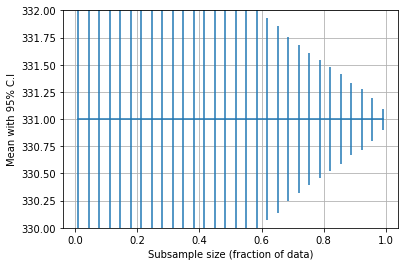

In [11]:
def subsample_variance(data, ratio):
    # convert the ratio into a subsample size
    size = round(len(data)*ratio)
    trials = [ # run query2 on a subsample of the dataset
               query2(random.sample(data, size))
               # rescale the result by the size of the subsample
               * len(data) / size
               for _ 
               #  do this 1000 times
               in range(0, 1000) 
             ]
    # compute the variance of all subsample trials
    return numpy.var(trials)

subsample_sizes = numpy.linspace(0.01, 0.99, 30)
plt.errorbar(subsample_sizes,
             [analytic_mean for _ in subsample_sizes],
             [ci_from_variance(subsample_variance(input_data, size), len(input_data) * size) \
              for size in subsample_sizes])
plt.grid()
plt.xlabel("Subsample size (fraction of data)")
plt.ylabel("Mean with 95% C.I")
plt.ylim((330,332));

This plot shows that running `query2` (the raw query) on a subsample introduces
noise into the result, and we can visualize this variance as a 95% CI. In a
previous plot we visualized in a similar way running `query3` (the
differentially private query) which also introduces noise into the result. Our
final question is then: given that subsampling and differential privacy both
introduce noise into the result, which choices of subsample size (for `query2`)
are equivalent to which choices of $epsilon$ (for `query3`)? Let's make a plot
that relates these two values, and for different sizes of the original dataset.

(Creating the next plot takes more than a few seconds to generate.)

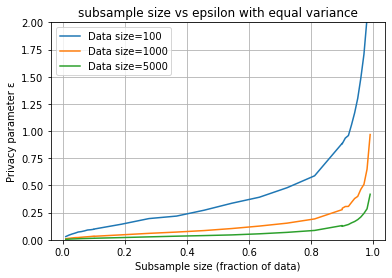

In [12]:
def epsilon_from_variance(variance):
    sensitivity = 1
    return sensitivity / numpy.sqrt(variance / 2)

input_data_large = sum([input_data for _ in range(0, 5)], [])

# Create a plot with:
# - 10 points between 0.01 and 0.10
# - 10 points between 0.10 and 0.9
# - 10 points between 0.9 and 0.99
subsample_sizes = numpy.concatenate([numpy.linspace(0.01, 0.10, 10),
                                     numpy.linspace(0.10, 0.9, 10),
                                     numpy.linspace(0.9, 0.99, 10)])

def graph_size(size):
    ys = [epsilon_from_variance(subsample_variance(input_data_large[0:(size-1)], x)) \
          for x in subsample_sizes]
    plt.plot(subsample_sizes, ys, label=f"Data size={size}")

graph_size(100)
graph_size(1000)
graph_size(5000)

plt.title("subsample size vs epsilon with equal variance")
plt.xlabel("Subsample size (fraction of data)")
plt.ylabel("Privacy parameter ε")
plt.ylim((0, 2))
plt.grid()
plt.legend();

As you can see, for the small (size = 100) dataset in the experiment, an
$\epsilon$ value of 1 introduces the same amount of noise as taking a subsample
of 90% of the dataset. For the large (size = 5000) dataset in the experiment, an
$\epsilon$ value of 1 introduces the same amount of noise as dropping a
negligibly small number of rows (just 1 or 2) from the dataset.

Note that this experiment is likely *highly* dependent on the specific query
*and* the dataset in question, which in this case is just a simple counting
query performed over naively generated synthetic data. For this reason, these
results should *not* be interpreted as relating distribution variance due to
$\epsilon$ and subsample size choice in general.